In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")

In [5]:
dev = tch.device("cuda")
dtype = tch.float32

In [6]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [7]:
def make_images(img: np.ndarray) -> Tensor:
    return tch.from_numpy(img).to(dev).type(dtype) / 255.0

In [8]:
def sample_fig(gen: nn.Module, z: Tensor):
    gen.train(False)

    n = z.shape[0]
    images = gen.forward(z).sigmoid().detach().to("cpu").numpy()
    fig, axs = plt.subplots(1, n)
    for i in range(n):
        ax = axs[i]
        ax.axis('off')
        ax.imshow(images[i], interpolation='nearest')

    return fig

In [15]:
from genpg.model import Encoder, Decoder

image_dims = test_images.shape[1:]
latent_dim = 128

conv_channels = [[1]]
kernel_size = 3
fc_dims = [784, 1024, 256]

gen = Decoder([latent_dim, *reversed(fc_dims)], [list(reversed(s)) for s in reversed(conv_channels)], kernel_size, image_dims, dropout=True).to(dev)
print(gen)
dis = Encoder(image_dims, conv_channels, kernel_size, [*fc_dims, 1], dropout=True).to(dev)
print(dis)

Decoder(
  (mlp): Mlp(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=784, bias=True)
  )
  (up_conv): ConvNet(
    (0): ConvLayer(
      (convs): Sequential()
    )
  )
)
Encoder(
  (conv): ConvNet(
    (0): ConvLayer(
      (convs): Sequential()
    )
  )
  (mlp): Mlp(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [16]:
batch_size = 1024
gen_dis_steps_ratio = 1.0

gen_optim = tch.optim.AdamW(
    gen.parameters(),
    lr=1e-4,
)
dis_optim = tch.optim.AdamW(
    dis.parameters(),
    lr=1e-4,
)

'epoch = 99'

{'generator_loss': np.float64(2.46639672780441),
 'discriminator_loss': np.float64(0.026790764056524988)}

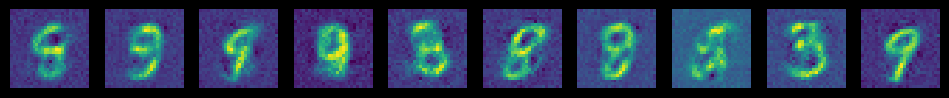

In [19]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits
from genpg.dataset import generate_batches
from genpg.notebook import Display
from genpg.utils import Accum

display = Display()
test_noise = tch.randn((10, latent_dim), device=dev)
order_counter = 0.0

for epoch in range(100):

    gen.train(True)
    dis.train(True)

    stats = Accum("generator_loss", "discriminator_loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        if order_counter >= 0.0:
            order_counter -= 1.0
            train_gen = True
        else:
            order_counter += gen_dis_steps_ratio
            train_gen = False

        if train_gen:
            gen.zero_grad()

            z = tch.randn((batch_size, latent_dim), device=dev)
            x = gen.forward(z)

            labels = tch.zeros(x.shape[0]).to(dev)
            logits = dis.forward(x).squeeze(1)

            loss = bce_with_logits(logits, labels)

            loss.backward()
            gen_optim.step()

            stats.append(loss.item(), 0.0)

        else:
            dis.zero_grad()

            z = tch.randn((batch_size, latent_dim), device=dev)
            x_fake = gen.forward(z)

            x_real = images
            x = tch.cat((x_real, x_fake), 0)
            labels = tch.cat((tch.zeros(x_real.shape[0]), tch.ones(x_fake.shape[0])), 0).to(dev)
            logits = dis.forward(x).squeeze(1)

            loss = bce_with_logits(logits, labels)

            loss.backward()
            dis_optim.step()

            stats.append(0.0, loss.item())

    fig = sample_fig(gen, test_noise)

    display.clear()
    display.update(f"{epoch = }", )
    display.update(stats.mean())
    display.update(fig)
    plt.close()

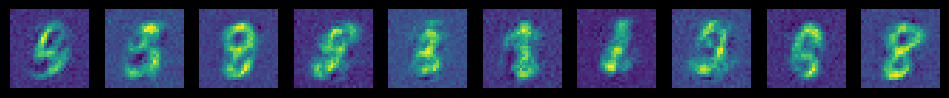

In [20]:
sample_fig(gen, tch.randn((10, latent_dim), device=dev)).show()